In [1]:
# Based on https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
import pandas as pd 
import numpy as np

In [7]:
df = pd.read_csv('ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [75]:
n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' items')

610 users
9724 items


In [86]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    if row[2] <= n_items:
        ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [88]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 1.31%


In [90]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

%time fast_similarity(ratings)

CPU times: user 247 ms, sys: 9.34 ms, total: 256 ms
Wall time: 154 ms


array([[1.00000000e+00, 6.25378380e-02, 6.34627574e-02, ...,
        3.00029346e-01, 9.35719300e-02, 2.21304637e-01],
       [6.25378380e-02, 1.00000000e+00, 5.63400399e-12, ...,
        1.09175018e-01, 6.31854678e-02, 7.39237589e-02],
       [6.34627574e-02, 5.63400399e-12, 1.00000000e+00, ...,
        2.31414497e-02, 2.65507104e-12, 3.62360068e-02],
       ...,
       [3.00029346e-01, 1.09175018e-01, 2.31414497e-02, ...,
        1.00000000e+00, 1.25735914e-01, 4.69159754e-01],
       [9.35719300e-02, 6.31854678e-02, 2.65507104e-12, ...,
        1.25735914e-01, 1.00000000e+00, 8.10554390e-02],
       [2.21304637e-01, 7.39237589e-02, 3.62360068e-02, ...,
        4.69159754e-01, 8.10554390e-02, 1.00000000e+00]])

In [107]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        rs = ratings[user, :].nonzero()[0]
        test_ratings = np.random.choice(rs, 
                                        size=min(10, len(rs)), 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

train, test = train_test_split(ratings)

In [108]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

user_similarity = fast_similarity(train, kind='user')
%time predict_fast_simple(train, user_similarity, kind='user')

item_similarity = fast_similarity(train, kind='item')
%time predict_fast_simple(train, item_similarity, kind='item')

CPU times: user 323 ms, sys: 8.88 ms, total: 332 ms
Wall time: 169 ms
CPU times: user 6.39 s, sys: 547 ms, total: 6.94 s
Wall time: 5.84 s


array([[4.32329467e-01, 4.06877572e-01, 4.22286141e-01, ...,
        3.51447971e-07, 3.51447971e-07, 3.51447971e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.06631145e-02, 9.80098076e-03, 1.03703136e-02, ...,
        5.74351647e-08, 5.74351647e-08, 5.74351647e-08],
       ...,
       [9.59424463e-01, 1.00041816e+00, 8.59031569e-01, ...,
        1.03244625e-06, 1.03244625e-06, 1.03244625e-06],
       [4.38178747e-02, 4.15619411e-02, 3.44669211e-02, ...,
        3.95551439e-08, 3.95551439e-08, 3.95551439e-08],
       [7.57904174e-01, 6.99460979e-01, 5.32084521e-01, ...,
        9.79473092e-07, 9.79473092e-07, 9.79473092e-07]])

In [110]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)


item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 9.631357422193618
Item-based CF MSE: 13.579474593870833


In [113]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

pred = predict_topk(train, user_similarity, kind='user', k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

/Users/rchaves/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/Users/rchaves/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k User-based CF MSE: 8.195905090679135


/Users/rchaves/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/Users/rchaves/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k Item-based CF MSE: 10.333448084940104


In [114]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]

/Users/rchaves/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/Users/rchaves/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/Users/rchaves/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

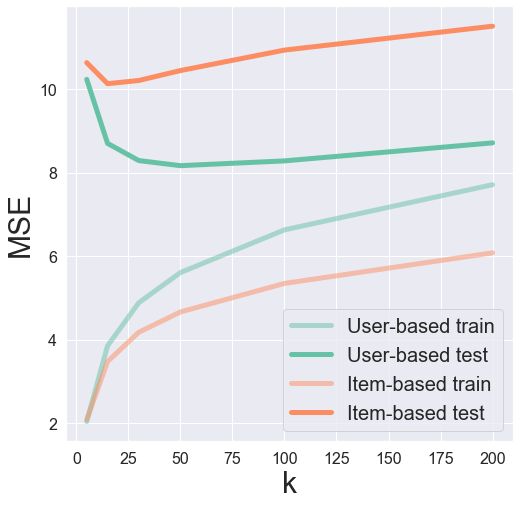

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [142]:
movieslist = pd.read_csv('ml-latest-small/movies.csv')
movieslist.head()

idx_to_movie = {}
for i, row in movieslist.iterrows():
    idx_to_movie[row.movieId-1] = row.title

idx_to_movie

{0: 'Toy Story (1995)',
 1: 'Jumanji (1995)',
 2: 'Grumpier Old Men (1995)',
 3: 'Waiting to Exhale (1995)',
 4: 'Father of the Bride Part II (1995)',
 5: 'Heat (1995)',
 6: 'Sabrina (1995)',
 7: 'Tom and Huck (1995)',
 8: 'Sudden Death (1995)',
 9: 'GoldenEye (1995)',
 10: 'American President, The (1995)',
 11: 'Dracula: Dead and Loving It (1995)',
 12: 'Balto (1995)',
 13: 'Nixon (1995)',
 14: 'Cutthroat Island (1995)',
 15: 'Casino (1995)',
 16: 'Sense and Sensibility (1995)',
 17: 'Four Rooms (1995)',
 18: 'Ace Ventura: When Nature Calls (1995)',
 19: 'Money Train (1995)',
 20: 'Get Shorty (1995)',
 21: 'Copycat (1995)',
 22: 'Assassins (1995)',
 23: 'Powder (1995)',
 24: 'Leaving Las Vegas (1995)',
 25: 'Othello (1995)',
 26: 'Now and Then (1995)',
 27: 'Persuasion (1995)',
 28: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 29: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 30: 'Dangerous Minds (1995)',
 31: 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995

In [194]:
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

def get_movie_idx(movieslist, title):
    return movieslist[movieslist['title'] == title]['movieId'][0] - 1 

In [195]:
idx = get_movie_idx(movieslist, "Toy Story (1995)") 
movies = top_k_movies(item_similarity, idx_to_movie, idx)
movies

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Jurassic Park (1993)',
 'Forrest Gump (1994)',
 'Groundhog Day (1993)']

In [150]:
from sklearn.metrics import pairwise_distances
# Convert from distance to similarity
item_correlation = 1 - pairwise_distances(train.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0.

In [151]:
movies = top_k_movies(item_correlation, idx_to_movie, idx)
display(movies)

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 'Groundhog Day (1993)',
 "Bug's Life, A (1998)",
 'Star Wars: Episode IV - A New Hope (1977)',
 'Ghostbusters (a.k.a. Ghost Busters) (1984)']

In [196]:
k = 6
idx = 0 # First user
similar_users = [ idx + 1 for idx in np.argsort(user_similarity[idx,:])[:-k-1:-1] ]
print(similar_users)
df[df['userId'].isin(similar_users)].set_index('userId').sort_values('userId')#['title'].value_counts()

[1, 561, 590, 480, 266, 313]


,movieId,rating,timestamp,title,genres
userId,,,,,
1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3578,5.0,964980668,Gladiator (2000),Action|Adventure|Drama
1,1587,5.0,964982346,Conan the Barbarian (1982),Action|Adventure|Fantasy
1,1580,3.0,964981125,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi
1,3617,4.0,964980683,Road Trip (2000),Comedy
1,1573,5.0,964982290,Face/Off (1997),Action|Crime|Drama|Thriller
1,3639,4.0,964982271,"Man with the Golden Gun, The (1974)",Action|Adventure|Thriller
1,1552,4.0,964982620,Con Air (1997),Action|Adventure|Thriller
1,3671,5.0,964981589,Blazing Saddles (1974),Comedy|Western
